<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/UV_Stellar_Catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [1]:
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install synphot --quiet

     |████████████████████████████████| 914 kB 5.6 MB/s 


# **GitHub**

In [2]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 1515, done.
remote: Counting objects: 100% (391/391), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 1515 (delta 194), reused 376 (delta 185), pack-reused 1124
Receiving objects: 100% (1515/1515), 242.29 MiB | 37.76 MiB/s, done.
Resolving deltas: 100% (806/806), done.


In [3]:
cd INSIST/data

/content/INSIST/data


#**Imports**

In [147]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from astropy.table import Table, join
from astropy.io import fits

import os
from time import perf_counter
import json
import requests
from scipy.interpolate import interp1d
from scipy import integrate

import mastcasjobs
from scipy.optimize import minimize_scalar,minimize

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

matplotlib.rcParams['font.size']=15
matplotlib.rcParams['figure.figsize']=(15,10)
sb.set_style('darkgrid')

# **Data**

## **CasJobs Script**

In [ ]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
class casjobs():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None ,cols = None):   

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
          self.query =   f"""select psc.objid,o.raStack,o.decStack,mag.gPSFMag, mag.gPSFMagErr,mag.rPSFMag, mag.rPSFMagErr,mag.iPSFMag, mag.iPSFMagErr,mag.zPSFMag,mag.zPSFMagErr, mag.yPSFMag,mag.yPSFMagErr,psc.ps_score
                            from fGetNearbyObjEq({self.ra}, {self.dec}, 28) f
                            join ObjectThin o on o.objid=f.objid
                            join HLSP_PS1_PSC.pointsource_scores psc on psc.objid=f.objid
                            join StackObjectThin mag on mag.objid=psc.objid
                            WHERE
                            mag.gPSFMag>-900 and 
                            mag.rPSFMag>-900 and 
                            mag.iPSFMag>-900 and 
                            mag.zPSFMag>-900 and 
                            mag.yPSFMag>-900 
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else:
          self.df = df 
        if cols is not None:
          self.df = self.df.rename(columns=cols) 
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n  {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
        

## **M 31**

In [5]:
df_M31 = Table.read('/content/INSIST/data/M31_UVIT_PanSTARRS_crossmatch.fits').to_pandas()

In [6]:
df_star = df_M31[df_M31['ps_score']>0.5].copy()
df_star =  df_star.rename(columns = {'raStack':'ra','decStack':'dec'})

In [7]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000             # mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.082        # mJy

In [8]:
df_star['NUVFlux']     = 3631*pow(10,-df_star['NUV']/2.5)*1000             # mJy
df_star['NUVFlux_err'] = (df_star['NUV_err']*df_star['NUVFlux'])/1.082        # mJy

df_star['FUVFlux']     = 3631*pow(10,-df_star['FUV']/2.5)*1000             # mJy
df_star['FUVFlux_err'] = (df_star['FUV_err']*df_star['FUVFlux'])/1.082        # mJy

In [9]:
df_star['objid'] = [str(i) for i in df_star['objid']]

In [59]:
df_star = df_star[:1]
df_star

,RAJ2000,DEJ2000,FUV,FUV_err,NUV,NUV_err,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,...,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err,NUVFlux,NUVFlux_err,FUVFlux,FUVFlux_err
0,10.8947,41.3926,21.499,19.098,20.857,0.188,20.7313,0.02506,20.9541,0.033309,...,0.007752,0.000566,0.010246,0.001246,0.005421,0.002719,0.01649,0.002865,0.009129,0.161134


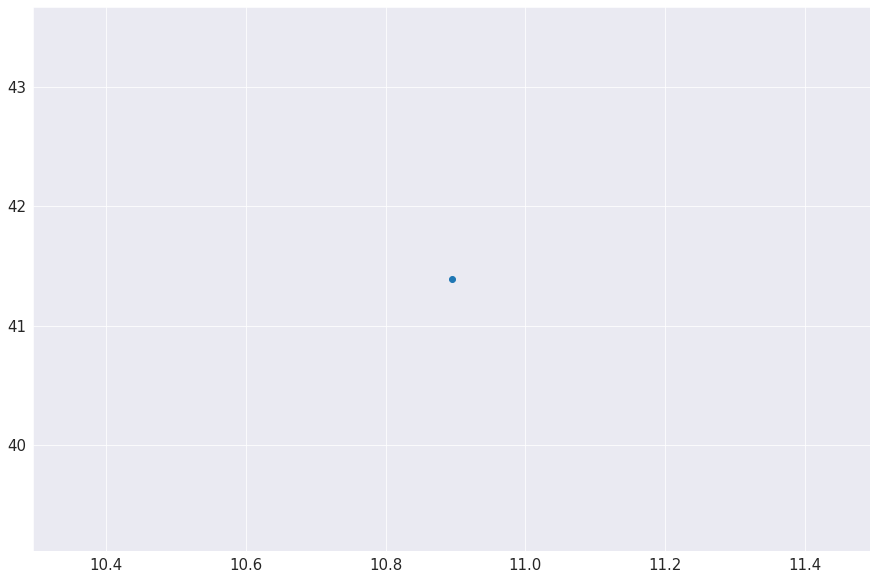

In [60]:
x = df_star['RAJ2000'].values
y = df_star['DEJ2000'].values
plt.scatter(x,y)

# **Synthetic Spectra**

## **Synphot**

#### **Model**

In [12]:
os.environ['PYSYN_CDBS'] = '/content/INSIST/data'

In [13]:
!mkdir '/content/INSIST/data/grid'

In [14]:
cd '/content/INSIST/data/grid/'

/content/INSIST/data/grid


In [15]:
!wget http://ssb.stsci.edu/trds/tarfiles/synphot3.tar.gz

--2022-07-11 06:50:09--  http://ssb.stsci.edu/trds/tarfiles/synphot3.tar.gz
Resolving ssb.stsci.edu (ssb.stsci.edu)... 130.167.165.20
Connecting to ssb.stsci.edu (ssb.stsci.edu)|130.167.165.20|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ssb.stsci.edu/trds/tarfiles/synphot3.tar.gz [following]
--2022-07-11 06:50:09--  https://ssb.stsci.edu/trds/tarfiles/synphot3.tar.gz
Connecting to ssb.stsci.edu (ssb.stsci.edu)|130.167.165.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18076806 (17M) [application/octet-stream]
Saving to: ‘synphot3.tar.gz’

synphot3.tar.gz     100%[===================>]  17.24M  35.1MB/s    in 0.5s    

2022-07-11 06:50:10 (35.1 MB/s) - ‘synphot3.tar.gz’ saved [18076806/18076806]



In [16]:
!tar -xf synphot3.tar.gz

In [17]:
!cp -a /content/INSIST/data/grid/grp/redcat/trds/grid/ck04models /content/INSIST/data/grid/

In [18]:
!rm -r grp

In [19]:
cat = Table.read('ck04models/catalog.fits')

In [21]:
filter_dict = {'UVIT_FUV': [1506.00,'Astrosat_UVIT.F148Wa.dat'],
               'UVIT_NUV': [2792.56,'Astrosat_UVIT.N279N.dat'],
               'SDSS.u ' : [3578.03, 'SLOAN_SDSS.u.dat'	],
               'PS1g'    : [4881.47, 'PAN-STARRS_PS1.g.dat' ],
               'PS1r'    : [6198.41, 'PAN-STARRS_PS1.r.dat' ],
               'PS1i'    : [7549.34, 'PAN-STARRS_PS1.i.dat' ],
               'PS1z'    : [8701.37, 'PAN-STARRS_PS1.z.dat' ],
               'PS1y'    : [9509.80,'PAN-STARRS_PS1.y.dat' ]
               }

#### **Convolving Filters**

In [47]:
conv_fluxes = []
model_fluxes = []
for f in cat['FILENAME']:
  wav = Table.read(f'ck04models/ckm05/ckm05_10000.fits')['WAVELENGTH'].value
  l = f.split('[')
  name        = l[0]
  col         = l[1][:3]
  tab         = Table.read(f'ck04models/{name}')
  flux        = tab[col].value # 
  model_func  = interp1d(wav,flux)
  fluxes      = []
  for filter in filter_dict:
    file_name = filter_dict[filter][1]
    filt_dat  = np.loadtxt(f'/content/INSIST/data/{file_name}')

    x         = filt_dat[:,0]
    y         = filt_dat[:,1]
    
    indices  = np.where( (wav>x[0]) & (wav<x[-1]))
    wav_new  = wav[indices]
    flux_new = flux[indices]

    x_new = [wav[0]] + [x[0]-1] + list(x) + [x[-1]+1] + [wav[-1]]
    y_new = [0]      + [0]      + list(y) +     [0]   + [0]
    
    filt_func = interp1d(x_new,y_new)

    filt_flux = model_func(wav)*filt_func(wav) # F(x)R(x)

    const     = integrate.simps(filt_flux*wav,wav)/integrate.simps(filt_func(wav)*wav, wav)

    filt_flux = interp1d(wav, filt_flux)    # erg/(s.cm2.A)

    lambd = integrate.simps(filt_func(wav)*wav,wav)/integrate.simps(filt_func(wav),wav) #filter_dict[filter][0]                            
 
    filt_flux_Jy =  (const*(lambd)**2*3.34e7)

    fluxes.append(filt_flux_Jy)
  conv_fluxes.append(fluxes)
  model_fluxes.append(flux)
conv_fluxes = np.array(conv_fluxes)

Text(0, 0.5, 'Flux | Response')

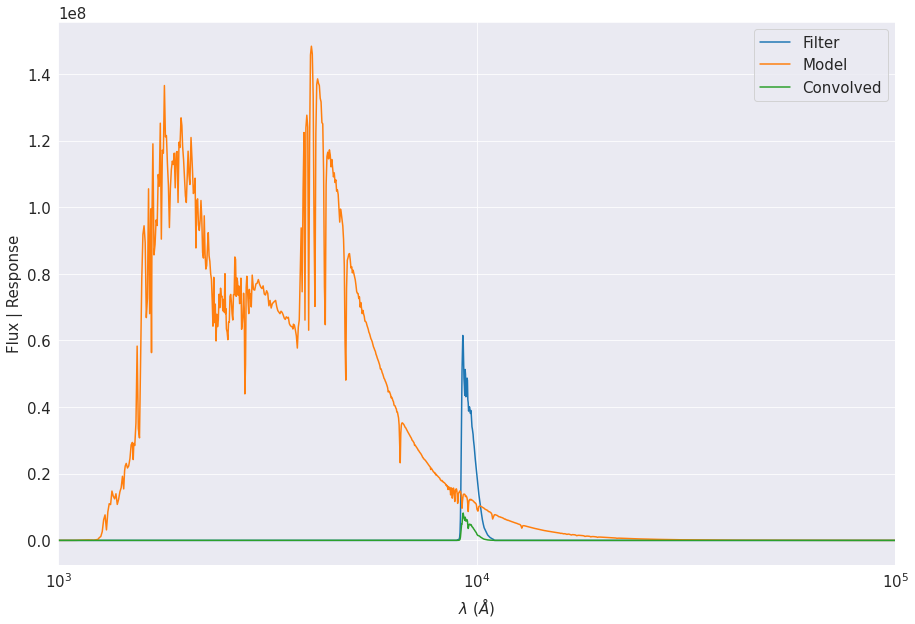

In [39]:
plt.plot(wav, filt_func(wav)*1e8)
plt.plot(wav, model_func(wav))
plt.plot(wav, filt_flux(wav))
plt.xscale('log')
plt.xlim(1e3,1e5)
plt.legend(['Filter','Model','Convolved'])
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel('Flux | Response')

In [131]:
df = cat[['INDEX']]
T = []
Met = []
logg = []
for i in cat['INDEX']:
  params = i.split(',')
  T.append(float(params[0]))
  Met.append(float(params[1]))
  logg.append(float(params[2]))
df['T'] = T
df['Met'] = Met
df['logg'] = logg
for i, filter in enumerate(filter_dict):
  df[filter + '_flux'] = conv_fluxes[:,i]
df['model_flux'] = model_fluxes

In [132]:
df.write('PanSTARRS_UVIT_conv.fits', overwrite = True)

In [133]:
model_df = Table.read('PanSTARRS_UVIT_conv.fits')

In [134]:
model_df

INDEX,T,Met,logg,UVIT_FUV_flux,UVIT_NUV_flux,SDSS.u _flux,PS1g_flux,PS1r_flux,PS1i_flux,PS1z_flux,PS1y_flux,model_flux [1221]
bytes20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32
"10000,-0.5,0.0",10000.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0
"10000,-0.5,0.5",10000.0,-0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0
"10000,-0.5,1.0",10000.0,-0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0
"10000,-0.5,1.5",10000.0,-0.5,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0
"10000,-0.5,2.0",10000.0,-0.5,2.0,8.77443901566323e+21,1.9565093447604116e+22,3.6121156153269293e+22,6.888360188359213e+22,5.535514368791355e+22,4.462123065537198e+22,4.015072464428563e+22,3.7520459359504707e+22,0.0 .. 0.02765
"10000,-0.5,2.5",10000.0,-0.5,2.5,9.271958408522081e+21,1.867212361220347e+22,3.441441538999875e+22,7.033519942846375e+22,5.549844704715426e+22,4.438026011087177e+22,3.981146309549996e+22,3.762970337821806e+22,0.0 .. 0.02756
"10000,-0.5,3.0",10000.0,-0.5,3.0,9.649210122526465e+21,1.846845666164104e+22,3.298054207145162e+22,7.081359981291456e+22,5.5512386086960175e+22,4.4288875104243554e+22,3.9364189063706434e+22,3.7534995651460585e+22,0.0 .. 0.02757
"10000,-0.5,3.5",10000.0,-0.5,3.5,9.890317049553115e+21,1.8667288248188456e+22,3.1756146784961877e+22,7.080002667750818e+22,5.555827567896798e+22,4.436894266534048e+22,3.894212278725792e+22,3.7350136582663743e+22,0.0 .. 0.02762
"10000,-0.5,4.0",10000.0,-0.5,4.0,9.950272121272491e+21,1.9150631981388938e+22,3.0835234249377623e+22,7.04863518854498e+22,5.5669675533462695e+22,4.459177162154327e+22,3.8626538119417154e+22,3.7107981612768867e+22,0.0 .. 0.02769


# **$Chi^2$ Fitting**

### **Without Av**

In [135]:
def chi2_func(Md,flux,model_flux,flux_err):
  chi = (flux - pow(10,Md)*model_flux)/flux_err
  return chi@chi

In [158]:
chi_set = []
for i,row_source in df_star.iterrows():

  flux     = row_source[['NUVFlux','gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux','yPSFFlux']].values
  flux_err = row_source[['NUVFlux_err','gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for row_model in model_df:

    model_flux = row_model[['UVIT_NUV_flux','PS1g_flux','PS1r_flux','PS1i_flux','PS1z_flux','PS1y_flux']].values()
    model_flux = np.array([i for i in model_flux])

    Md = minimize_scalar(chi2_func,args=(flux, model_flux, flux_err)).x
    chi2       = chi2_func(Md,flux,model_flux,flux_err)
    chi_set.append([row_source['objid'],row_model['T'],row_model['Met'],row_model['logg'],Md,chi2])

In [165]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','T','Met','logg','Md','chi2'])

In [166]:
len(df_chi)

6688

In [167]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [168]:
df_chi_min

,objid,T,Met,logg,Md,chi2
6023,157670108946911614,16000.0,0.5,3.0,-25.01365,32.653199


In [169]:
df_chi_min = Table.from_pandas(df_chi_min)

In [178]:
df_out = join(df_chi_min,model_df, keys = ['T','Met','logg'])

In [179]:
for i in ['PS1g_flux','PS1r_flux','PS1i_flux','PS1z_flux', 'PS1y_flux','UVIT_FUV_flux', 'UVIT_NUV_flux']:
  df_out[i]*=pow(10,df_out['Md'].value)
  df_out[i[:-4]+'mag_p'] = -2.5*np.log10(df_out[i]/3631000)

In [180]:
df_temp = Table.from_pandas(df_star)

In [181]:
df_final = join(df_temp,df_out, keys = 'objid')

In [182]:
df_final

RAJ2000,DEJ2000,FUV,FUV_err,NUV,NUV_err,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,objid,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err,NUVFlux,NUVFlux_err,FUVFlux,FUVFlux_err,T,Met,logg,Md,chi2,INDEX,UVIT_FUV_flux,UVIT_NUV_flux,SDSS.u _flux,PS1g_flux,PS1r_flux,PS1i_flux,PS1z_flux,PS1y_flux,model_flux [1221],PS1g_mag_p,PS1r_mag_p,PS1i_mag_p,PS1z_mag_p,PS1y_mag_p,UVIT_FUV_mag_p,UVIT_NUV_mag_p
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64
10.8947,41.3926,21.499,19.098,20.857,0.188,20.731300354003906,0.025059999898076057,20.954099655151367,0.033309001475572586,21.676599502563477,0.07899600267410278,21.373699188232422,0.1316239982843399,22.064899444580078,0.5427460074424744,0.8391309380531311,157670108946911614,0.018514249298778818,0.0004288050698154823,0.015079480737788897,0.0004642166785082058,0.0077515124318068,0.0005659320672748159,0.010245816502713936,0.0012463912511782628,0.005420838528700556,0.0027191667915365653,0.016490212375688047,0.0028652125015058713,0.009129063940507432,0.1611338845987162,16000.0,0.5,3.0,-25.013649718690118,32.65319922633945,"16000,0.5,3.0",0.013192651211995624,0.017579195495826778,1.838107073626048e+23,0.018828634144085397,0.01348902740603702,0.010095926337791156,0.008230395024374856,0.007259932063323592,0.0 .. 0.04046,20.713018580233328,21.07511402968488,21.389700189285136,21.611513922225694,21.74773423053948,21.099235420558426,20.787568132542205


In [175]:
df_final.write('M31_without_Av_with_NUV.fits')

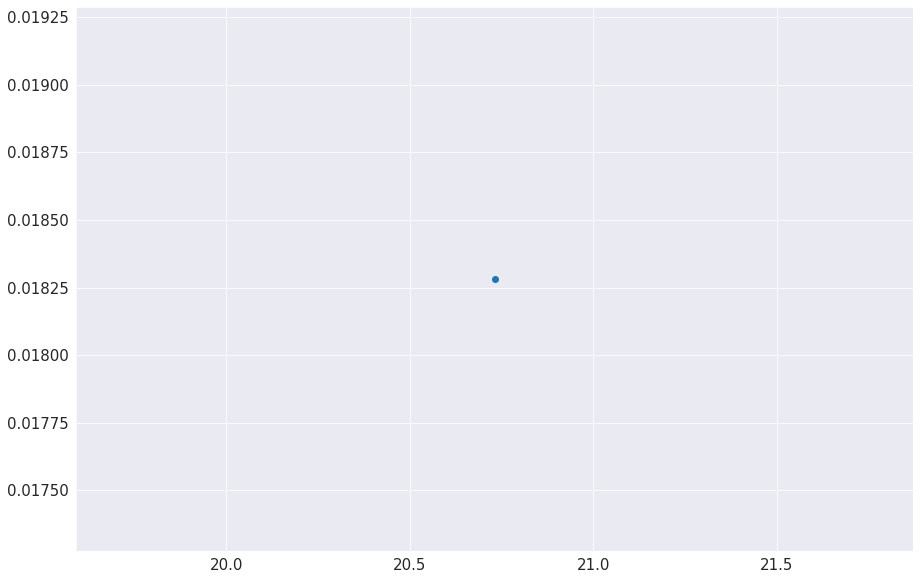

In [184]:
x = df_final['gPSFMag']
y = df_final['gPSFMag']-df_final['PS1g_mag_p']
plt.scatter(x.value,y.value)

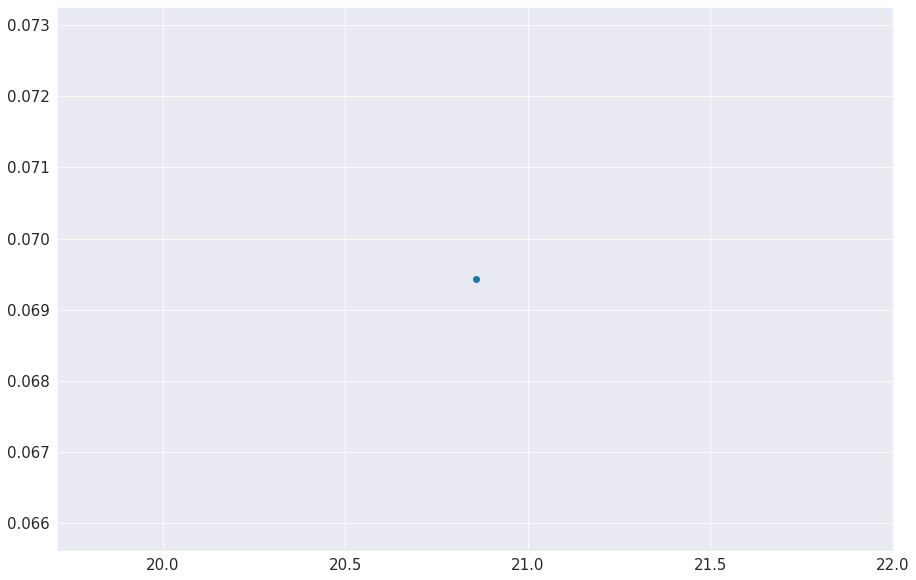

In [185]:
x = df_final['NUV']
y = df_final['NUV']-df_final['UVIT_NUV_mag_p']
plt.scatter(x.value,y.value)

In [186]:
obs_mag = ['FUV','NUV','gPSFMag', 'rPSFMag', 'iPSFMag','zPSFMag',  'yPSFMag', ]
mod_mag = ['UVIT_FUV_mag_p', 'UVIT_NUV_mag_p','PS1g_mag_p','PS1r_mag_p', 'PS1i_mag_p', 'PS1z_mag_p',  'PS1y_mag_p']

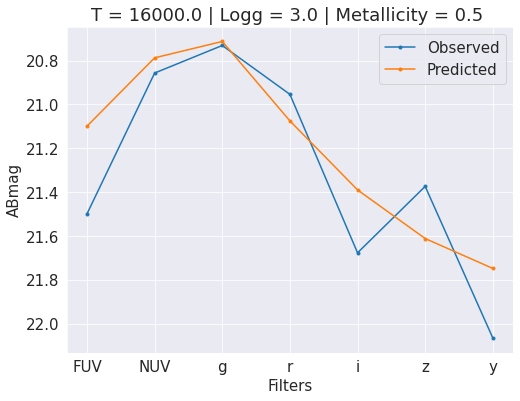

In [202]:
for n in range(len(df_final)):
  fig, ax = plt.subplots(figsize = (8,6))

  ax.plot(df_final[obs_mag].to_pandas().values[n],'.-',label = 'Observed' )
  ax.plot(df_final[mod_mag].to_pandas().values[n],'.-',label = 'Predicted')
  ax.set_xticks(range(7))
  ax.set_xticklabels(['FUV','NUV','g', 'r', 'i','z','y'])
  ax.set_xlabel('Filters')
  ax.set_ylabel('ABmag')
  ax.set_title(f"T = {df_final['T'][n]} | Logg = {df_final['logg'][n]} | Metallicity = {df_final['Met'][n]} ")
  ax.legend()
  ax.invert_yaxis()

In [201]:
df_final[obs_mag]['FUV'][0]

21.499

### **With Av**

In [ ]:
def chi2_func(params,flux,model_flux,flux_err,ext):
  Md, av = params
  chi = (flux - pow(10,Md)*model_flux*pow(10,-0.4*av*ext))/flux_err
  return chi@chi

In [ ]:
ext = np.array([1.17, 0.873, 0.664, 0.533,0.456])

chi_set = []
for i,row_source in df_star.iterrows():

  flux     = row_source[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux','yPSFFlux']].values
  flux_err = row_source[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j, row_model in model_df.iterrows():

    model_flux = row_model[['PS1gflux','PS1rflux','PS1iflux','PS1zflux','PS1yflux']].values

    params = minimize(chi2_func,x0 = (-25,0.5),bounds=([-30,-10],[0,20]),args=(flux,model_flux,flux_err,ext)).x
    Md, Av = params
    chi2   = chi2_func(params,flux,model_flux,flux_err,ext)
    chi_set.append([row_source['objid'],row_model['T'],row_model['Met'],row_model['logg'],Md,chi2,Av])

In [ ]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','T','Met','logg','Md','chi2','Av'])

In [ ]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [ ]:
df_chi_min

,objid,T,Met,logg,Md,chi2,Av
6044,157670108946911614,18000.0,0.5,2.5,-25.106492,33.217478,0.006157
10748,157670109428482384,7250.0,-2.5,0.5,-23.838692,24.153618,0.572393
16669,157680109486918074,8750.0,-2.0,2.0,-24.380681,14.431758,0.000000
23680,157660109250539020,25000.0,-2.5,4.0,-25.302294,2.378387,0.000000
33399,157660109780228245,9000.0,0.5,1.5,-23.474564,34.486188,0.161650
35750,157680109042526355,5500.0,-1.5,0.0,-22.292135,40.228247,0.469108
44178,157710109189987274,7000.0,-2.5,1.0,-22.679208,250.692107,1.743998
53401,157650109262013866,7500.0,0.5,3.5,-24.121636,19.317745,0.000000
57564,157700109471607579,7250.0,-2.5,0.5,-20.966603,13758.724182,0.937971
66835,157730108215714973,8750.0,0.5,5.0,-24.135681,2.571148,0.009120


In [ ]:
df_out = pd.merge(df_chi_min, model_df, on = ['T','Met','logg'])

In [ ]:
ext = np.array([2.67,1.95,1.17, 0.873, 0.664, 0.533,0.456])
for i, id in enumerate(['UVIT_FUV_flux', 'UVIT_NUV_flux','PS1gflux','PS1rflux','PS1iflux','PS1zflux', 'PS1yflux']):
  df_out[id]*= pow(10,df_out['Md'].values)*pow(10,-0.4*df_out['Av'].values*ext[i])
  df_out[id[:-4]+'_mag_p'] = -2.5*np.log10(df_out[id]/3631000)

In [ ]:
df_final = pd.merge(df_star,df_out, on = 'objid')

In [ ]:
obs_mag = ['FUV','NUV','gPSFMag', 'rPSFMag', 'iPSFMag','zPSFMag',  'yPSFMag', ]
mod_mag = ['UVIT_FUV__mag_p', 'UVIT_NUV__mag_p','PS1g_mag_p','PS1r_mag_p', 'PS1i_mag_p', 'PS1z_mag_p',  'PS1y_mag_p']

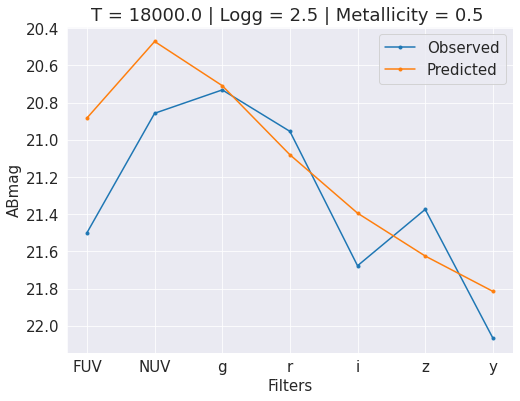

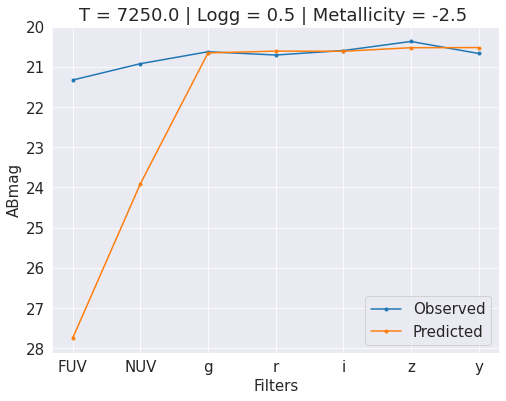

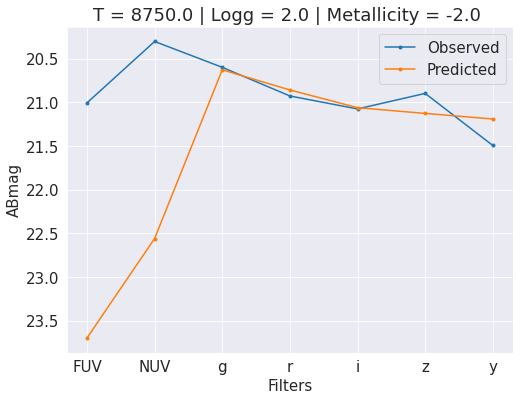

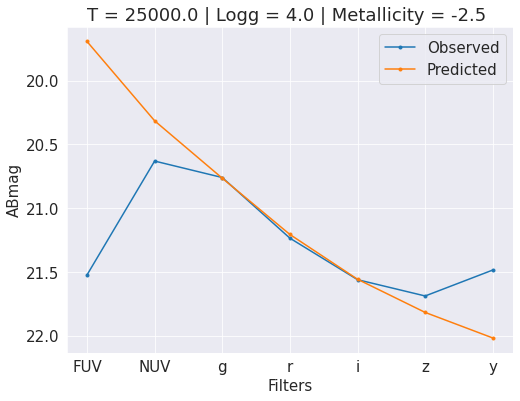

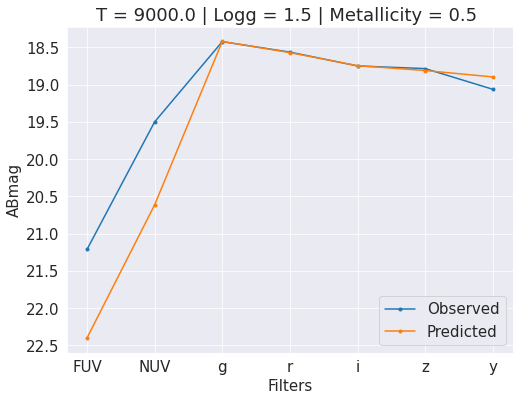

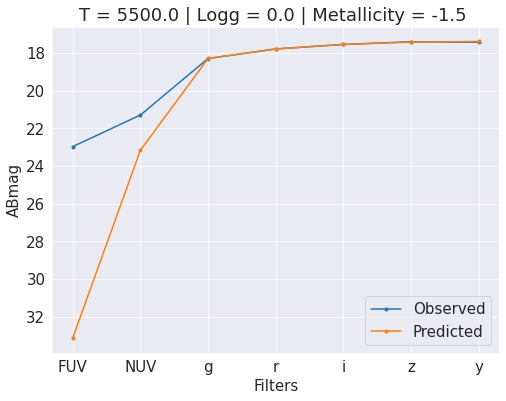

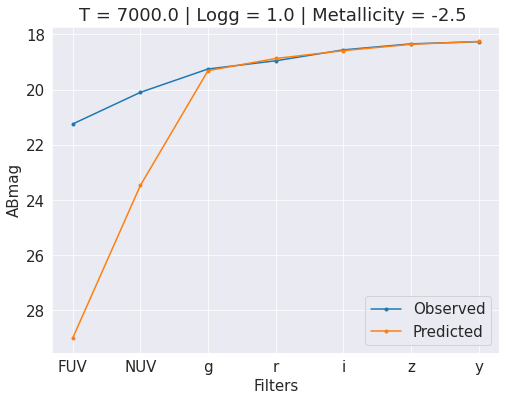

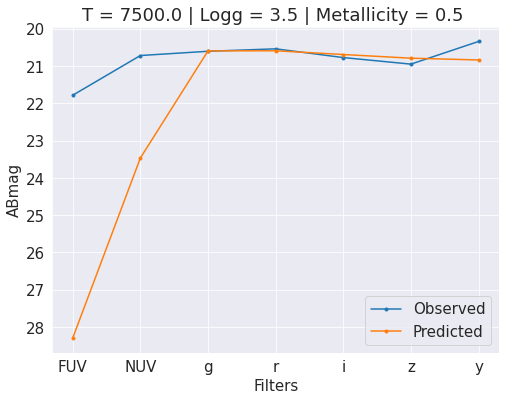

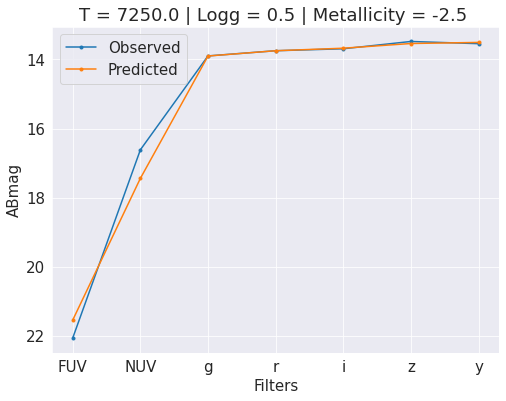

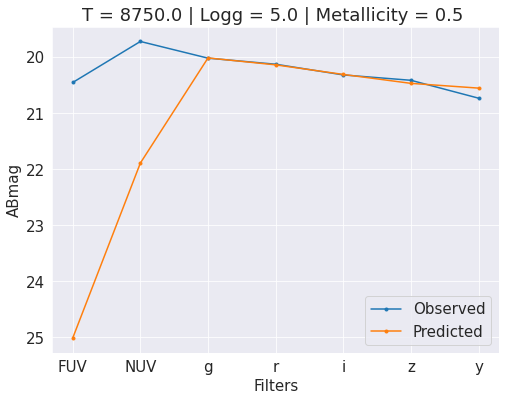

In [ ]:
for n in range(len(df_final)):
  fig, ax = plt.subplots(figsize = (8,6))

  ax.plot(df_final[obs_mag].values[n],'.-',label = 'Observed' )
  ax.plot(df_final[mod_mag].values[n],'.-',label = 'Predicted')
  ax.set_xticks(range(7))
  ax.set_xticklabels(['FUV','NUV','g', 'r', 'i','z','y'])
  ax.set_xlabel('Filters')
  ax.set_ylabel('ABmag')
  ax.set_title(f"T = {df_final['T'].values[n]} | Logg = {df_final['logg'].values[n]} | Metallicity = {df_final['Met'].values[n]} ")
  ax.legend()
  ax.invert_yaxis()